<a href="https://colab.research.google.com/github/ohjeonsuk/python-education/blob/main/L231108.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

딥러닝

- ANN

- 경사하강법

- 오차역전파

- Optimizer

- CNN

- ResNet

- RNN, LSTM, GRU

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [ ]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t]+1e-7)) / batch_size

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 값 복원
        it.iternext()

    return grad

def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용
    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx

In [ ]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr*grads[key]

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key])+1e-7)

class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():

            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

\begin{equation*}
f(x,y) = \frac{1}{20} x^2 + y^2
\end{equation*}

In [ ]:
def f(x, y):
    return x**2/20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)

parameter : x, y

grads : f(x,y) 기울기

In [ ]:
params = {}
grads = {}
grads['x'], grads['y'] = 0.0, 0.0

In [ ]:
optimizers = OrderedDict()

In [ ]:
optimizers['SGD'] = SGD(lr=0.95)
optimizers['Momentum'] = Momentum(lr=0.1)
optimizers['AdaGrad']=AdaGrad(lr=1.5)
optimizers['Adam'] = Adam(lr=0.3)

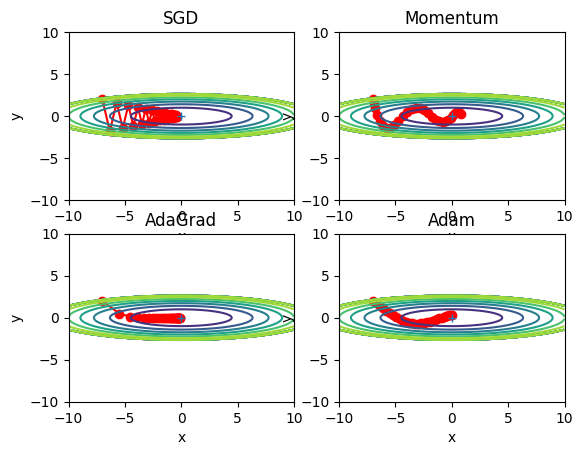

In [ ]:
idx = 1 #그래프용
for key in optimizers :
    optimizer = optimizers[key] #SGD, M, AG, A
    params['x'], params['y'] = init_pos[0], init_pos[1]

    x_history = []
    y_history = []

    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)

    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0

    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
plt.show()

optimizer 성능테스트 : mnist 데이터 사용, MultiLayerNet 클래스 사용

In [ ]:
from drive.MyDrive.data.mnist import load_mnist

In [ ]:
from drive.MyDrive.data.AnnUser import MultiLayerNet

In [ ]:
import drive.MyDrive.data.AnnUser as AU

In [ ]:
cat ./drive/MyDrive/data/AnnUser.py

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad']=AdaGrad()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}

for key in optimizers.keys():
    networks[key] = MultiLayerNet(input_size=784,
                                  hidden_size_list=[100, 100, 100, 100],
                                  output_size=10)
    train_loss[key] = []

for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i %100 == 0:
        print('=='*10, 'iteration : ', i, '=='*10)
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ' :: ', str(loss))

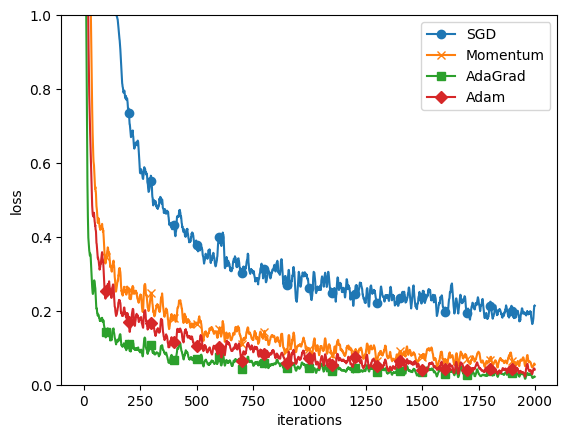

In [ ]:
markers = {'SGD':'o', 'Momentum':'x', 'AdaGrad':'s', 'Adam':'D'}
x = np.arange(max_iterations)

for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key )
plt.xlabel('iterations')
plt.ylabel('loss')
plt.ylim(0, 1)
plt.legend()
plt.show()

# 가중치의 초기값

#Xavier :  $\sqrt{1 \over n}$, sigmoid 혹은 tanh 함수 에 사용


#He : $ \sqrt{2 \over n} $, ReLu 에 주로 사용

가중치 초기화

    - W : 정규분포 -> x*W = 0

    - b : 0

    - 기본 : 0.01 을 곱해서 가중치를 초기화 한다. -> 과적합 방지(회귀 예)

#은닉층의 활성화값 분포

In [ ]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))
def ReLu(x):
    return np.maximum(0, x)
def tanh(x):
    return np.tanh(x)

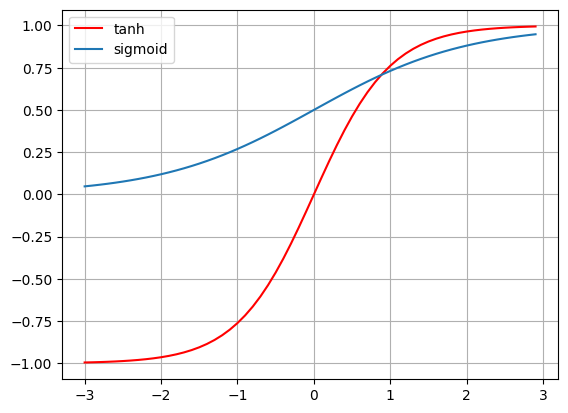

In [ ]:
x_ = np.arange(-3, 3, 0.1)
plt.plot(x_, tanh(x_), color='red', label='tanh')
plt.plot(x_, sigmoid(x_), label='sigmoid')
plt.legend()
plt.grid()

In [ ]:
input_data = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

x = input_data

def get_activation(hidden_layer_size, x, w, a_func=sigmoid):
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]
        a = np.dot(x, w)
        z = a_func(a)
        activations[i] = z
    return activations

w = np.random.randn(node_num, node_num) * 1 # scale = [1, 0.01, He, Xavier]
z = sigmoid
activations = get_activation(hidden_layer_size, x, w, z)

In [ ]:
activations.keys()

dict_keys([0, 1, 2, 3, 4])

In [ ]:
activations[3]

array([[0.99857185, 0.26148242, 0.99001409, ..., 0.08000401, 0.99015131,
        0.05427599],
       [0.9866954 , 0.95919161, 0.99989246, ..., 0.86961259, 0.99855144,
        0.02579054],
       [0.99971474, 0.08140512, 0.99959935, ..., 0.01523695, 0.88832049,
        0.03415468],
       ...,
       [0.94639527, 0.93783276, 0.99851597, ..., 0.80788203, 0.99993168,
        0.00203708],
       [0.99984867, 0.19364303, 0.99998604, ..., 0.95279242, 0.99231833,
        0.14395714],
       [0.99422267, 0.60586506, 0.87529071, ..., 0.99304117, 0.9916341 ,
        0.18995976]])

In [ ]:
activations.items()

In [ ]:
activations[0].flatten().shape

(100000,)

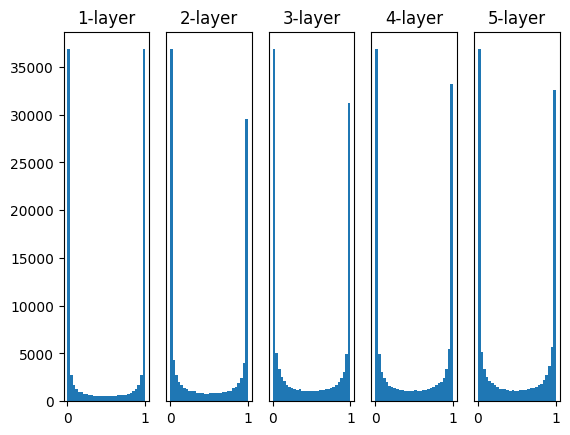

In [ ]:
def get_histogram(activations):
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
        # plt.xlim(0.1, 1)
        # plt.ylim(0, 7000)
        plt.hist(a.flatten(), 30, range=(0,1))
    plt.show()

get_histogram(activations)

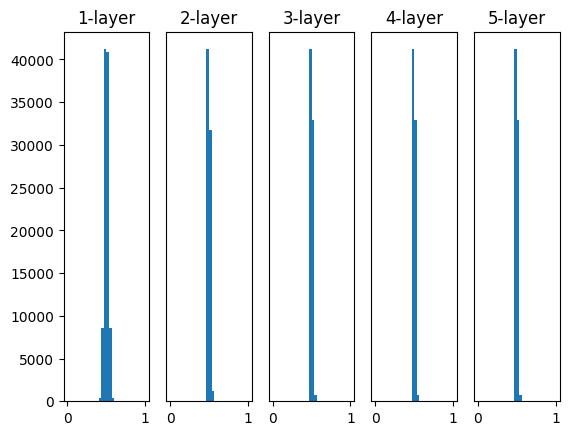

In [ ]:
w = np.random.randn(node_num, node_num) * 0.01 # scale = [1, 0.01, He, Xavier]
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

He 초기값 사용

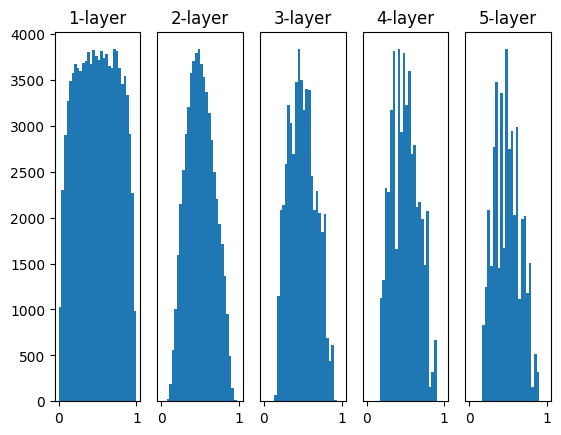

In [ ]:
w = np.random.randn(node_num, node_num) * np.sqrt(2.0/node_num) # scale = [1, 0.01, He, Xavier]
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

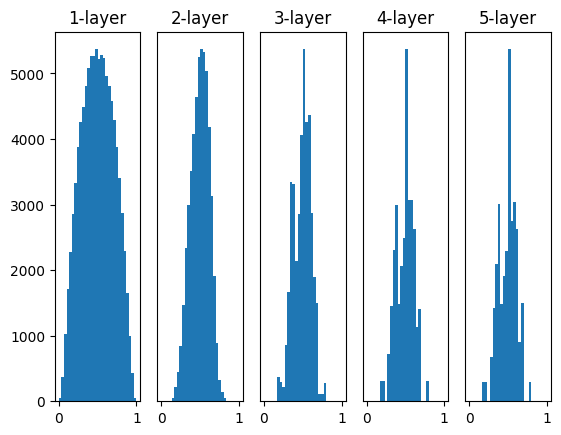

In [ ]:
w = np.random.randn(node_num, node_num) * np.sqrt(1.0/node_num) # scale = [1, 0.01, He, Xavier]
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

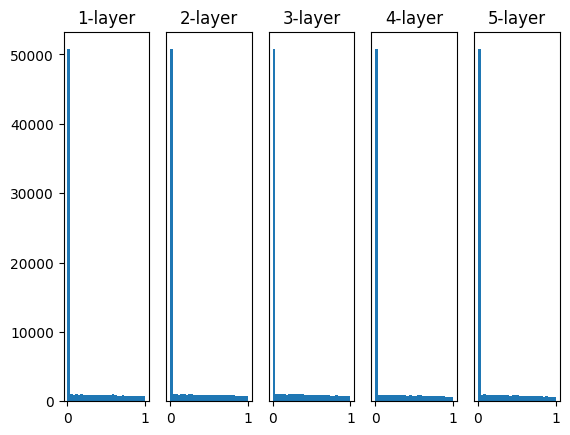

In [ ]:
w = np.random.randn(node_num, node_num) * np.sqrt(2.0/node_num) # scale = [1, 0.01, He, Xavier]
z = ReLu
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

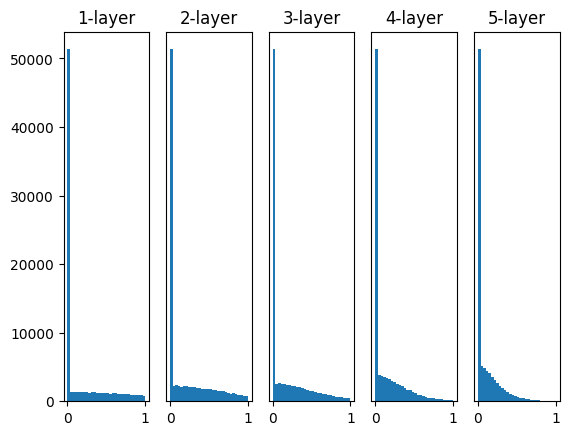

In [ ]:
w = np.random.randn(node_num, node_num) * np.sqrt(1.0/node_num) # scale = [1, 0.01, He, Xavier]
z = ReLu
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

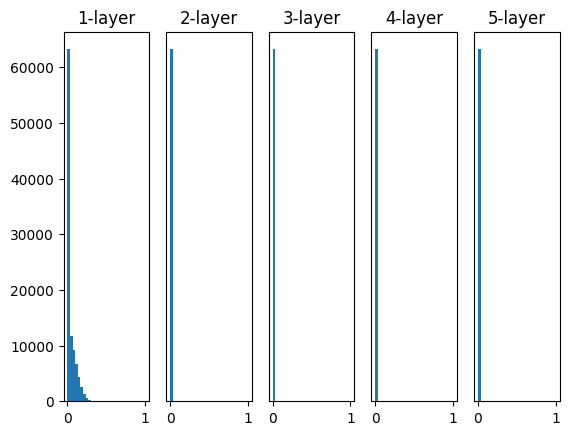

In [ ]:
w = np.random.randn(node_num, node_num) * 0.01 # scale = [1, 0.01, He, Xavier]
z = ReLu
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

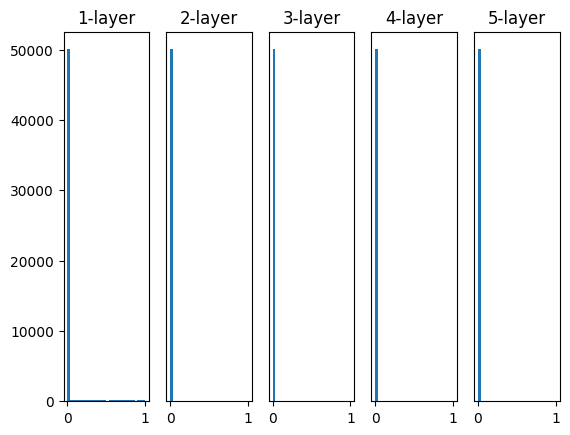

In [ ]:
w = np.random.randn(node_num, node_num) * 1 # scale = [1, 0.01, He, Xavier]
z = ReLu
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

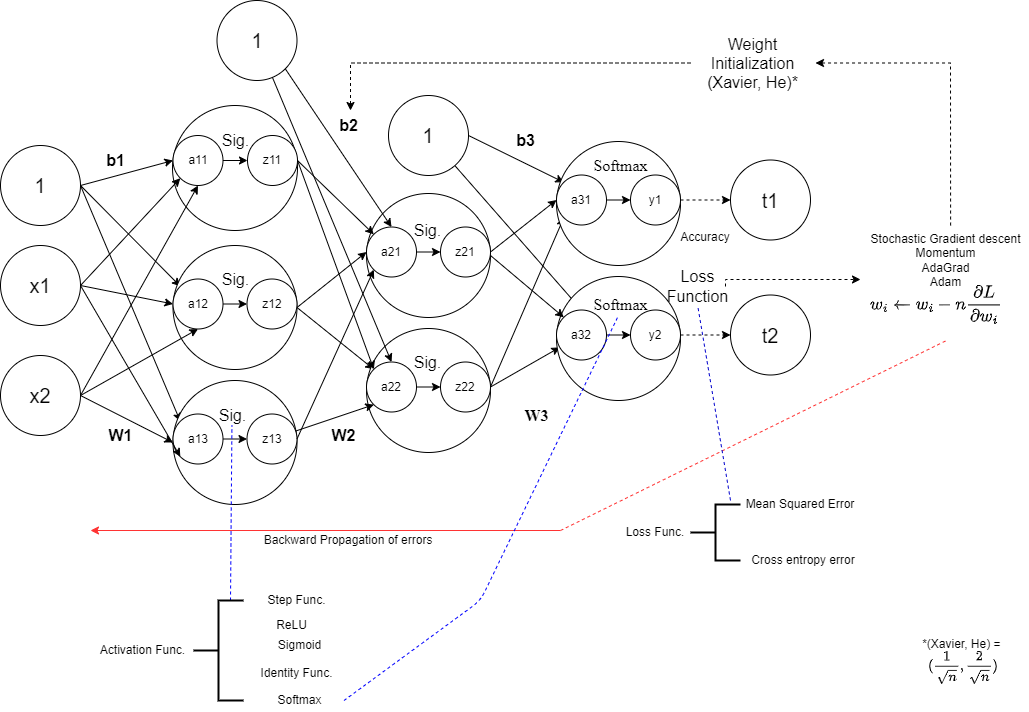

가중치 초기값에 따른 MNIST 데이터의 비용함수 변화

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

In [ ]:
cat ./drive/MyDrive/data/AnnUser.py

==================== iteration :  0 ====================
std=0.01  :  2.3025241545006585
Xavier  :  2.29727314545348
He  :  2.301527826587975
==================== iteration :  100 ====================
std=0.01  :  2.301317565760759
Xavier  :  2.236838275868755
He  :  1.737686014638997
==================== iteration :  200 ====================
std=0.01  :  2.302264147082428
Xavier  :  2.1334963417621484
He  :  0.8175103522908291
==================== iteration :  300 ====================
std=0.01  :  2.3013706263905895
Xavier  :  1.821214117483522
He  :  0.5290255323311299
==================== iteration :  400 ====================
std=0.01  :  2.3031957257912605
Xavier  :  1.2055830587853453
He  :  0.40461518183102085
==================== iteration :  500 ====================
std=0.01  :  2.298993437042607
Xavier  :  0.7751902659575172
He  :  0.3236213028486755
==================== iteration :  600 ====================
std=0.01  :  2.3031388941767945
Xavier  :  0.6742025887541248
He  :  

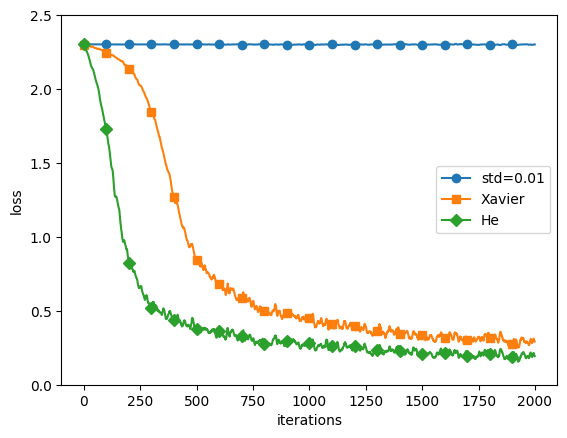

In [ ]:
train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

weight_init_types = {'std=0.01':0.01, 'Xavier':'sigmoid', 'He':'relu'}
optimizer = SGD(lr=0.01)

networks={}
train_loss={}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784,
                                  hidden_size_list=[100, 100, 100, 100],
                                  output_size=10,weight_init_std=weight_type)
    train_loss[key] = []

for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in weight_init_types:
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 ==0:
        print('=='*10, 'iteration : ', i, '=='*10)
        for key in weight_init_types:
            loss = networks[key].loss(x_batch, t_batch)
            print(key, ' : ', loss)

markers = {'std=0.01':'o', 'Xavier':'s', 'He':'D'}
x = np.arange(max_iterations)
for key in weight_init_types:
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key )
plt.xlabel('iterations')
plt.ylabel('loss')
plt.ylim(0, 2.5)
plt.legend()
plt.show()

#dropout

- 과적합 방지를 위해 사용

- 노드를 임의 삭제하면서 학습하는 방법

- 삭제노드는 무작위로 선택

- test : 모든 노드를 사용해 계산, 학습시 삭제된 노드의 비율을 출력에 곱하여 준다.

In [ ]:
class Dropout:
    def __init__(self, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x*self.mask
        else:
            return x*(1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

In [ ]:
x=np.array([[1, 2], [3, 4]])

In [ ]:
x.shape

(2, 2)

In [ ]:
x_ = np.random.rand(*x.shape)

In [ ]:
x_

array([[0.26564066, 0.26571694],
       [0.5047083 , 0.76745048]])

In [ ]:
mask_ = x_ > 0.4

In [ ]:
mask_

array([[False, False],
       [ True,  True]])

In [ ]:
x * mask_ #shape 같은 행렬끼리 곱 -> 원소끼리 곱

array([[0, 0],
       [3, 4]])

드롭아웃 테스트

In [ ]:
class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01},
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum,
                                'adagrad':AdaGrad, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)

        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]

        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)

        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))

        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1

            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]

            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

In [ ]:
cat ./drive/MyDrive/data/AnnUser.py

In [ ]:
from drive.MyDrive.data.AnnUser import MultiLayerNetExtend

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

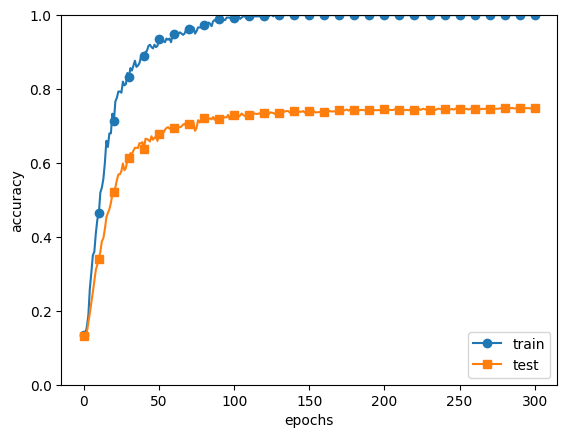

In [ ]:
x_train = x_train[:300]
t_train = t_train[:300]

use_dropout = False
dropout_ratio = 0.2

network = MultiLayerNetExtend(input_size=784,
                              hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout,
                              dropout_ration= dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr':0.01}, verbose=False)

trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


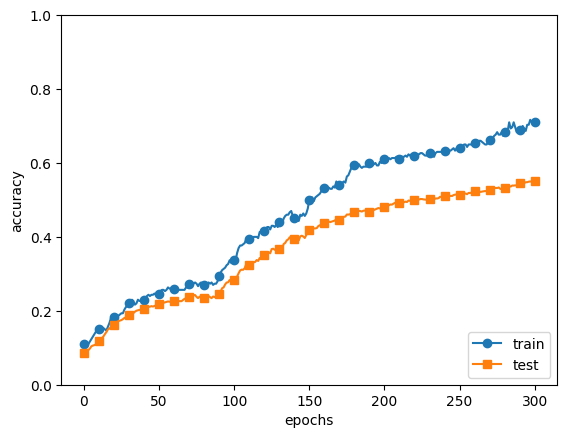

In [ ]:
x_train = x_train[:300]
t_train = t_train[:300]

use_dropout = True
dropout_ratio = 0.2

network = MultiLayerNetExtend(input_size=784,
                              hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout,
                              dropout_ration= dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr':0.01}, verbose=False)

trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#케라스

 - 파이썬으로 작성된 오픈소스 신경망 라이브러리

 - feed forward : 순전파

    - 입력층 데이터가 입력되고,

    은닉층을 거쳐서,

    마지막 출력층에 데이터를 보내는 과정

    - 이전층에서 나온 출력값이 가중치의 영향을 받은 다음, 다음 층의 입력 값으로 사용 되는 것

- 케라스의 백앤드 엔진

    텐서플로, 씨아노, CNTK


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Sequential 클래스

    - 레이어를 하나씩 연결하여 모델을 구성할 수 있게 해주는 클래스

    - 입력층, 은닉층, 출력층을 구성할수 있게 해준다.

In [ ]:
model = Sequential()
model.add(Dense(64))
model.add(Activation('tanh'))

In [ ]:
model.add(Dense(64, input_dim=3, activation='tanh'))

Dense

- 완전 연결층 (입력층과 출력층이 모두 연결되어 있는 것을 의미)

- 첫번째 위치 인자 : 출력층 노드 수 (64)

- activation

    - linear : 디폴트 값으로 별도 활성화 함수 없이 입력 뉴런과 가중치의 계산 결과 그대로 출력.

    - sigmoid : 이진 분류 문제에서 출력층에 주로 사용되는 활성화 함수.

    - softmax : 셋 이상의 선택지 중 하나를 택하는 다중 클래스 분류 문제에서 출력층에 주로 사용되는 활성화 함수.

    - relu : 은닉층에 주로 사용되는 활성화 함수.

- input_dim

    - 자료의 특성 개수를 의미하며, 보통, DataFrame의 column 개수와 일치 한다.

    - 예> mnist의 경우 784(=28*28)이 된다.

#모델구축 순서

1. keras.models 로부터 Sequential 클래스를 가져온다.

2. add() 메서드를 이용해 층을 만들어 간다.

3. compile() 메서드를 사용해 학습 과정을 구성한다.

4. fit() 메서드로 훈련 데이터셋을 사용해 모델을 훈련 시킨다.

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=100))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
from tensorflow.keras.utils import plot_model

Dense, 1

입력층, 3

relu

In [ ]:
model = Sequential()
model.add(Dense(1, input_dim=3, activation='relu'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1)                 4         
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


위 코드를 그려보면 아래와 같다

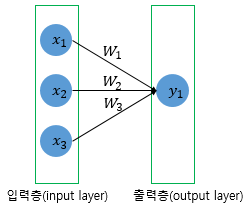

입력층의 노드개수 : 4개

1층의 노드개수 : 8개, activation : relu

2층의 노드개수 : 1개 , activation : sigmoid

In [ ]:
model = Sequential()
model.add(Dense(8, input_dim=4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

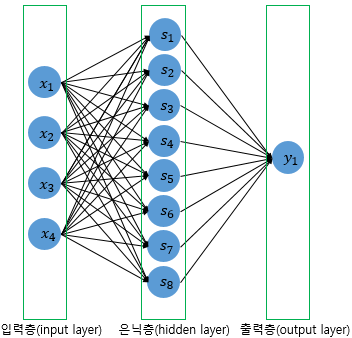

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 8)                 40        
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 49 (196.00 Byte)
Trainable params: 49 (196.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


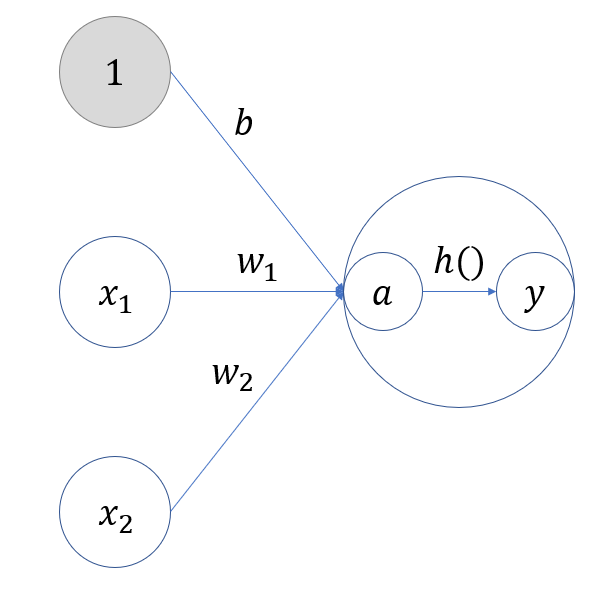

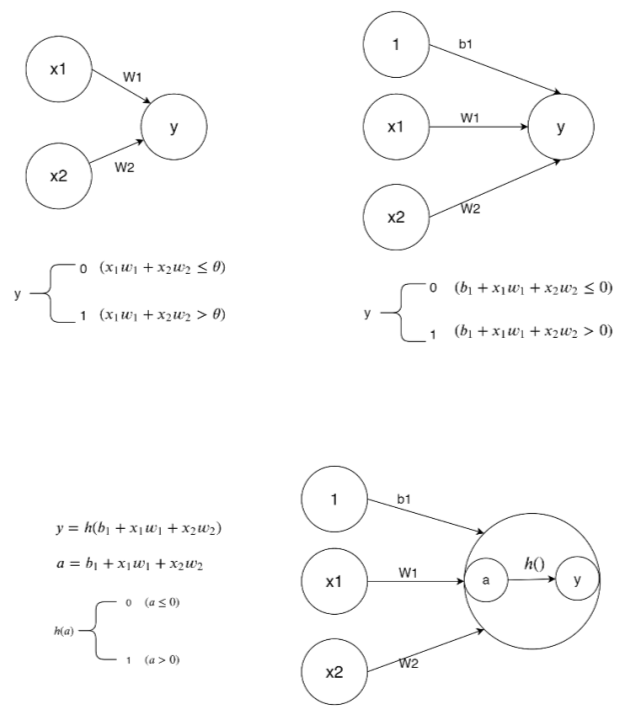

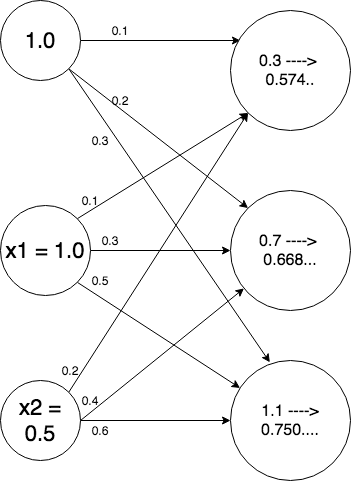